In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NF-X1"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn088191,MSSQFRNDRTDNNNRSRFAQSGRREWVPRGSADNTSASSTGTVANP...,1101,1
1,Achn141391,MTSSTHRPAPLPSSDSDADSDTSPTAADLRHTDLSATIFRSYLEIT...,839,1
2,Achn320981,MSSQFRNHRTDNNRSRFSQSGRRERVPRGSAANTSASSTGTLANPP...,1123,1
3,EMT04829,MPSSYAAAAASSSRKPAPFTTATATTRKPAPLPAPAPPPSNPSHVS...,798,1
4,EMT09587,MVLKGKLSDKDGVFSCSEVCGHNLACGNHACQDVCHPGPCGECELV...,766,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
494,0.016529,0.000000,0.000000,0.008264,0.000000,0.004132,0.00000,0.004132,0.008264,0.000000,...,0.000000,0.0,0.000000,0.004132,0.004132,0.000000,0.0000,0.0,0.0,0.0
219,0.007673,0.007673,0.003410,0.003410,0.003410,0.005115,0.00682,0.001705,0.001705,0.005115,...,0.000853,0.0,0.000853,0.000000,0.000853,0.000000,0.0000,0.0,0.0,0.0
270,0.009365,0.007284,0.006243,0.001041,0.002081,0.004162,0.00000,0.002081,0.001041,0.004162,...,0.000000,0.0,0.001041,0.000000,0.000000,0.001041,0.0000,0.0,0.0,0.0
38,0.004374,0.002625,0.000000,0.005249,0.001750,0.006124,0.00000,0.000000,0.002625,0.004374,...,0.001750,0.0,0.000000,0.001750,0.001750,0.000000,0.0000,0.0,0.0,0.0
524,0.000000,0.000000,0.000000,0.005000,0.002500,0.000000,0.00250,0.002500,0.002500,0.000000,...,0.002500,0.0,0.002500,0.002500,0.002500,0.000000,0.0025,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (630, 440)
X_test: (158, 440)
y_train: (630,)
y_test: (158,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,161 (610.00 KB)

 Trainable params: 156,161 (610.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 624ms/step - accuracy: 0.4062 - loss: 0.6934

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5716 - loss: 0.6913 - val_accuracy: 0.9762 - val_loss: 0.6805


Epoch 2/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9219 - loss: 0.6809

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9599 - loss: 0.6739 - val_accuracy: 0.9683 - val_loss: 0.6420


Epoch 3/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.6434

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9882 - loss: 0.6244 - val_accuracy: 0.9524 - val_loss: 0.5462


Epoch 4/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.5504

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.5086 - val_accuracy: 0.9683 - val_loss: 0.3654


Epoch 5/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.3684

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.3122 - val_accuracy: 0.9841 - val_loss: 0.1643


Epoch 6/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.1384

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.1262 - val_accuracy: 0.9762 - val_loss: 0.0676


Epoch 7/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0437

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0331 - val_accuracy: 0.9921 - val_loss: 0.0337


Epoch 8/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0110

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9841 - val_loss: 0.0312


Epoch 9/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0145

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0083 - val_accuracy: 0.9921 - val_loss: 0.0156


Epoch 10/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0075

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0117


Epoch 11/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0018

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9841 - val_loss: 0.0291


Epoch 12/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.7718e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0108


Epoch 13/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0014

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9921 - val_loss: 0.0142


Epoch 14/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0053

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9841 - val_loss: 0.0237


Epoch 15/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0030

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0077


Epoch 16/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 6.0640e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5078e-04 - val_accuracy: 1.0000 - val_loss: 0.0112


Epoch 17/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0032

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0089


Epoch 18/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.4883e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0049


Epoch 19/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.1460e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5089e-04 - val_accuracy: 0.9841 - val_loss: 0.0180


Epoch 20/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 9.9327e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7765e-04 - val_accuracy: 1.0000 - val_loss: 0.0070



[Train Accuracy: 100.00% - Test Accuracy: 99.37%]


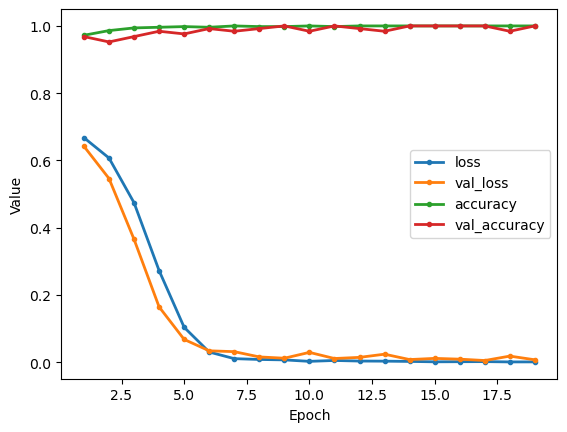

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
494,0.004149,0.000000,0.000000,0.004149,0.0,0.000000,0.0,0.0,0.004149,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,0.001706,0.000853,0.000000,0.000853,0.0,0.000853,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,0.001042,0.000000,0.001042,0.000000,0.0,0.001042,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.000000,0.000000,0.000000,0.000876,0.0,0.000876,0.0,0.0,0.000000,0.000876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (630, 8242)
X_test: (158, 8242)
y_train: (630,)
y_test: (158,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,110,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,153,473 (8.21 MB)

 Trainable params: 2,153,473 (8.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 632ms/step - accuracy: 0.4844 - loss: 0.6931

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5884 - loss: 0.6916 - val_accuracy: 0.9841 - val_loss: 0.6771


Epoch 2/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9688 - loss: 0.6779

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9882 - loss: 0.6681 - val_accuracy: 0.9841 - val_loss: 0.6176


Epoch 3/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.6219

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9896 - loss: 0.5951 - val_accuracy: 0.9921 - val_loss: 0.4809


Epoch 4/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.4670

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9897 - loss: 0.4309 - val_accuracy: 1.0000 - val_loss: 0.2567


Epoch 5/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.2737

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9919 - loss: 0.2158 - val_accuracy: 1.0000 - val_loss: 0.0683


Epoch 6/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0719

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 0.0113


Epoch 7/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0082

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0026


Epoch 8/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0034

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 9.4993e-04


Epoch 9/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.7573e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.8559e-04 - val_accuracy: 1.0000 - val_loss: 5.0390e-04


Epoch 10/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.8657e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.8024e-04 - val_accuracy: 1.0000 - val_loss: 3.6712e-04


Epoch 11/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.8170e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.2842e-04 - val_accuracy: 1.0000 - val_loss: 3.5384e-04


Epoch 12/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5314e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.5388e-04 - val_accuracy: 1.0000 - val_loss: 2.7275e-04


Epoch 13/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.4958e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.6233e-04 - val_accuracy: 1.0000 - val_loss: 2.1019e-04


Epoch 14/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.8096e-04

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.5156e-04 - val_accuracy: 1.0000 - val_loss: 2.0620e-04



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


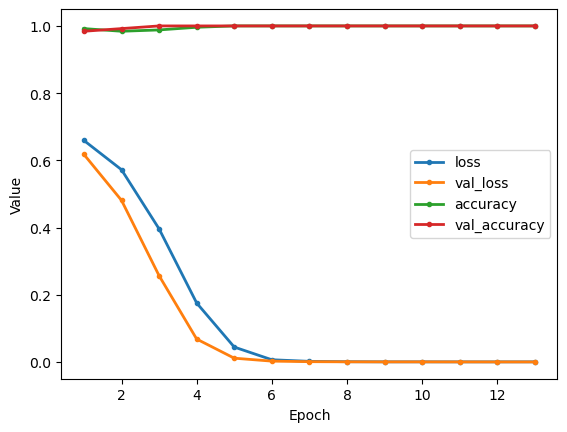

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYH,YYYL,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYX,YYYY
494,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004167,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,0.000854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      23,331,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,373,057 (89.16 MB)

 Trainable params: 23,373,057 (89.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 635ms/step - accuracy: 0.5312 - loss: 0.6931

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5234 - loss: 0.6931 

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5208 - loss: 0.6931

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5264 - loss: 0.6930

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5380 - loss: 0.6929

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5551 - loss: 0.6928

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5727 - loss: 0.6927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5897 - loss: 0.6925

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6029 - loss: 0.6924 - val_accuracy: 1.0000 - val_loss: 0.6868


Epoch 2/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9062 - loss: 0.6872

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9180 - loss: 0.6865

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9193 - loss: 0.6860

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9248 - loss: 0.6853

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9298 - loss: 0.6846

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9346 - loss: 0.6839

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9385 - loss: 0.6831

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9415 - loss: 0.6822

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9438 - loss: 0.6816 - val_accuracy: 1.0000 - val_loss: 0.6588


Epoch 3/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.6552

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.6537

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.6524

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9990 - loss: 0.6509

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9986 - loss: 0.6493

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9984 - loss: 0.6474

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9980 - loss: 0.6454

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9977 - loss: 0.6434

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9976 - loss: 0.6419 - val_accuracy: 1.0000 - val_loss: 0.5893


Epoch 4/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.5812

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.5774

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.5729

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.5693

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.5652

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9996 - loss: 0.5610

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9993 - loss: 0.5570

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9991 - loss: 0.5530

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9990 - loss: 0.5499 - val_accuracy: 1.0000 - val_loss: 0.4575


Epoch 5/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.4430

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.4327

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.4253

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.4179

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.4108

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.4043

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.3980

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.3918

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.3870 - val_accuracy: 1.0000 - val_loss: 0.2581


Epoch 6/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.2243

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.2174

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.2118

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.2059

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.2005

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1950

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1899

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1851

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.1815 - val_accuracy: 1.0000 - val_loss: 0.1049


Epoch 7/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0710

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0702

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0677

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0649

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0624

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0601

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0581

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0563

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0550 - val_accuracy: 1.0000 - val_loss: 0.0358


Epoch 8/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0190

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0177

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0171

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0168

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0164

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0159

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0154

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0150

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 1.0000 - val_loss: 0.0202


Epoch 9/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0045

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0045

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0046

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0045

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0046

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0046

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0046

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0046

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0107


Epoch 10/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0031

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0029

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0030

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0029

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0028

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0028

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0027

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0026

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0070


Epoch 11/100


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0014

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0014

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0014

4/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0014

5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0014

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0014

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0014

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0014

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0054



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


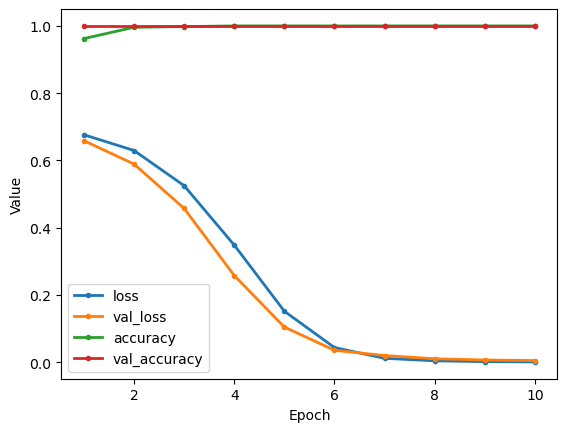

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/NF-X1/report_IVZQ6NXM.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################